## Import the modules/dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## load the data and have a quick look

In [3]:
arrests_df = pd.read_csv('UsArrests.csv')

display(arrests_df.head())

print('There are', arrests_df.shape[0], 'states and', arrests_df.shape[1], 'columns')


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


There are 50 states and 5 columns


Looking at column statistics and data types

In [4]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

display(arrests_df.describe().transpose())
print(arrests_df.dtypes)

,count,mean,std,min,25%,50%,75%,max
Murder,50.00,7.79,4.36,0.80,4.08,7.25,11.25,17.40
Assault,50.00,170.76,83.34,45.00,109.00,159.00,249.00,337.00
UrbanPop,50.00,65.54,14.47,32.00,54.50,66.00,77.75,91.00
Rape,50.00,21.23,9.37,7.30,15.07,20.10,26.18,46.00


City         object
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object


At first glance, we can see that there are loads of assaults... that could be a problem later in the PCA.

Find any missing data

In [5]:
missing_data = arrests_df.isnull().sum()
missing_data

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

There are no missing values in this dataset, great!


## Plotting the distribution of each column

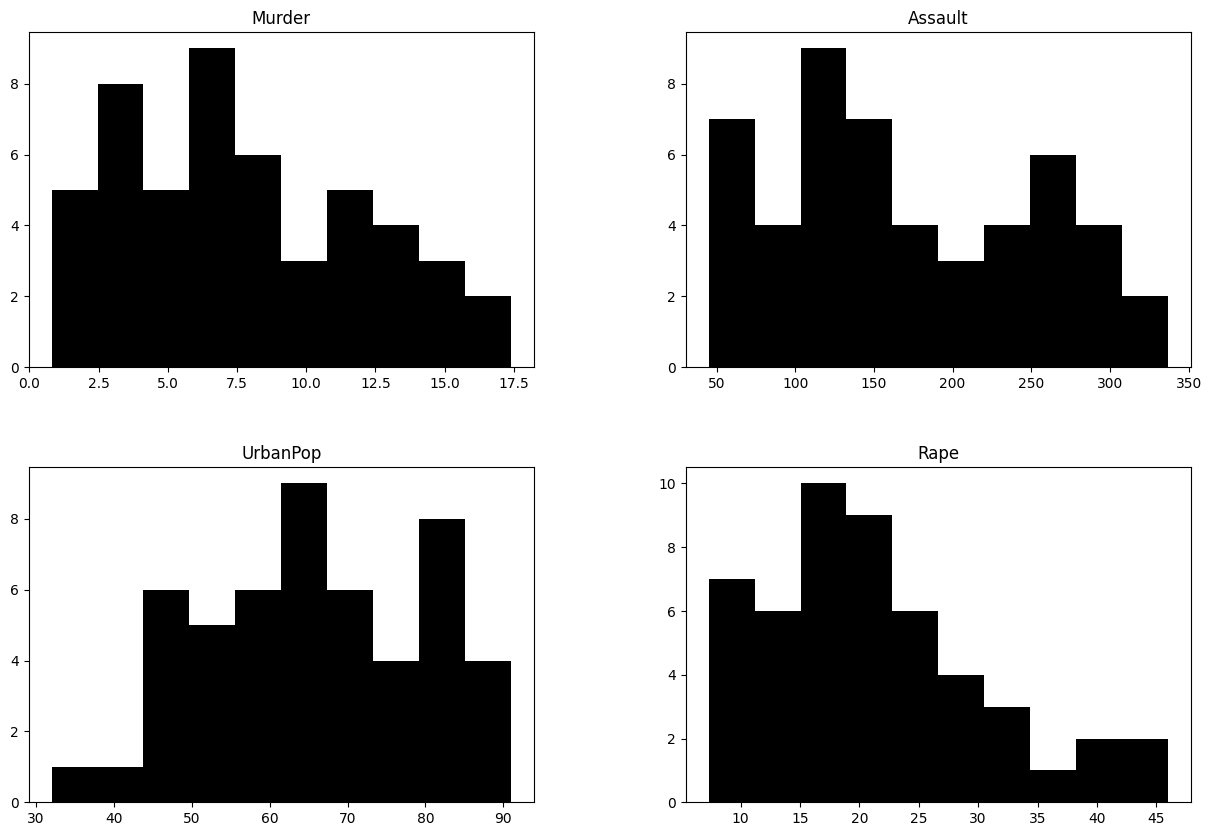

In [6]:
hists = arrests_df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.show()

It looks like the distribution of murder and assault crimes are quite similar. Maybe most assaults ended up in murders as well.

On the other hand, the were around 15-22 rapes per 100,000 people in that year. 

## Correlation analysis
Let's analyse if there is a relationship between variables.

<AxesSubplot:>

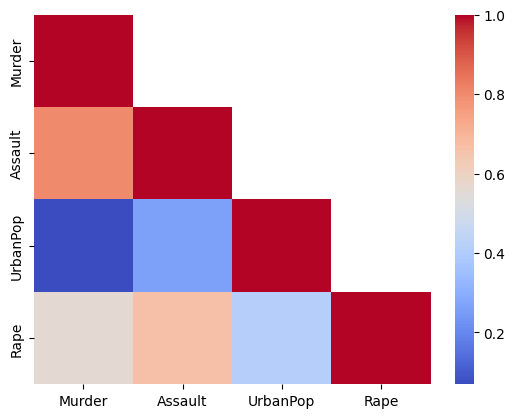

In [7]:
# Calcualte correlation
correlation = arrests_df.drop('City', axis= 1).corr()

#Plot the correlations in a heatmap
masking=np.triu(np.ones(correlation.shape), 1).astype(bool)
sns.heatmap(correlation, mask=masking, cmap="coolwarm")

Looks like there is a strong positive correlation between murders and assaults, i.e. as assaults increase murders increase too. This could confirm the previous observation from the histograma data, whereby most assaults could actually result in murder.

Interestingly, a similar relationship exists between assault and rape.
A weaker positive correlation exists between murder and rape too.

This may indicate the most crimes start just as an assault, but then they might end up either in a murder, in a rape, or both.

## Plotting the most dangerous states

Text(0.5, 1.0, 'Most rapes')

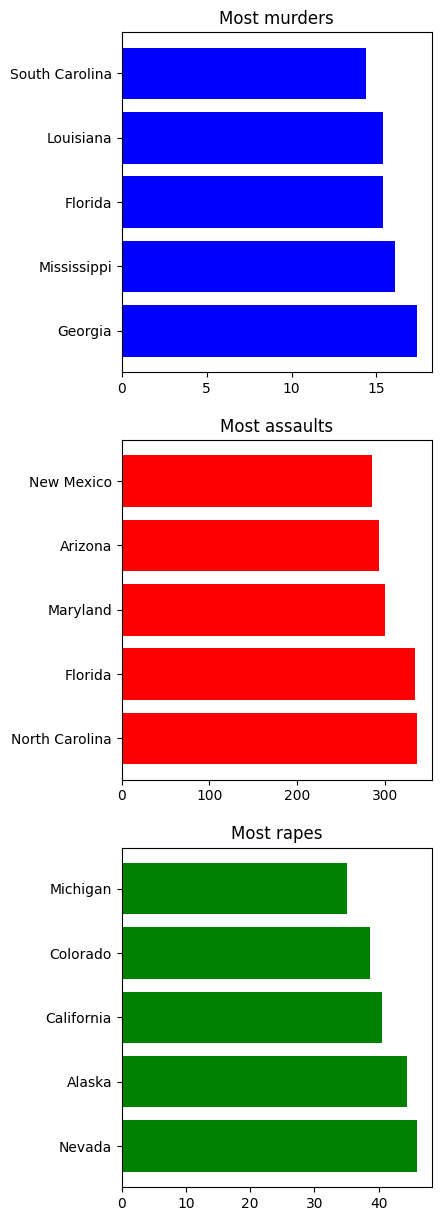

In [8]:
most_murders = arrests_df.sort_values(by = 'Murder', ascending= False).head()
most_assaults = arrests_df.sort_values(by = 'Assault', ascending= False).head()
most_rapes = arrests_df.sort_values(by = 'Rape', ascending= False).head()

# Plot

fig, ax = plt. subplots(3,1, figsize =(4,15))
ax[0].barh(most_murders['City'], most_murders['Murder'], color = 'b')
ax[0].set_title('Most murders')

ax[1].barh(most_assaults['City'], most_assaults['Assault'], color = 'r')
ax[1].set_title('Most assaults')

ax[2].barh(most_rapes['City'], most_rapes['Rape'], color = 'g')
ax[2].set_title('Most rapes')




From these barplot we can see that Florida is probably the most dangerous place in 1973. It was one of the top states for both murders and assaults.

On the other hand, the state with most rapes was Nevada.

## PCA
For PCA, we will first have a look at the result using the data as it is.
We noticed that the average number of assaults is quite high, which might swamp the rest of variable during PCA. If that's the case we will scale the data with StandardScaler()

In [9]:
from sklearn.decomposition import PCA

X = arrests_df.drop(["City"],axis=1).values

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [10]:
# Calculate standard deviation
std = df_pca.describe().transpose()["std"]

# Calculate proportionn of variance explained
explained_variance = pd.Series(pca.explained_variance_ratio_, name= 'Proportion of Variance Explained')

# Calculate cumulative proportion
cumulative_proportion = pd.Series(np.cumsum(pca.explained_variance_), name = 'Cumulative Proportion')

#Put all the data in a dataframe
std_variance_df = pd.concat([std, explained_variance, cumulative_proportion], axis=1).transpose()

std_variance_df

,0,1,2,3
std,83.73,14.21,6.49,2.48
Proportion of Variance Explained,0.97,0.03,0.01,0.00
Cumulative Proportion,7011.11,7213.11,7255.22,7261.38


It looks like the first component is largely swamping all others. 97% of proportion of explained vairance is attributed to the first PC. I suspect this is number of assaults being very high, as mentioned before.

We can also confirm this with a biplot.

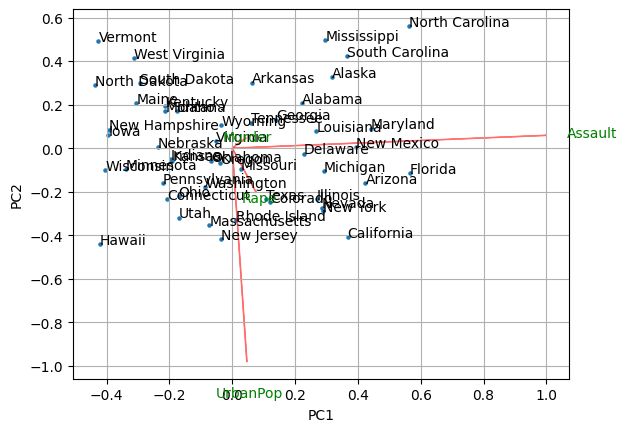

In [11]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = arrests_df['City'][i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(arrests_df.columns[1:]),list(arrests_df['City']))
plt.show()

In [12]:
# Feature importance
pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(arrests_df.columns[1:])
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.04,0.04
1,Assault,1.00,0.06
2,UrbanPop,0.05,0.98
3,Rape,0.08,0.20


It is confirmed that Assault is skewing the PCA a lot, as well as UrbanPop.

Let's scale the data and have another look.

## Data standardization

In [13]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


It is looking better now, let's check with the biplot too.

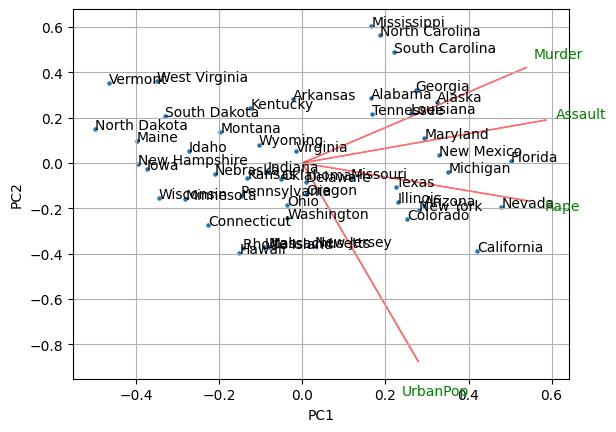

,Features,PC1 Importance,PC2 Importance
0,Murder,0.54,0.42
1,Assault,0.58,0.19
2,UrbanPop,0.28,0.87
3,Rape,0.54,0.17


In [14]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(arrests_df.columns[1:]))
plt.show()

# Feature importance
pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(arrests_df.columns[1:])
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

Now all variables contribute to the first two PCs more uniformely. Interestingly, UrbanPop is still quite dominant on the second PC.

Overall, the PC1 seems to summarise the level of criminality in a state, while PC2 seems to summarise the size of the state (% of urban population).

States with big cities are tipically more dangerous than smaller ones!

## Cluster analysis
To perform cluster analysis, we will need to understand how many components to select. To do that, we will look at how much variation is explained as more components are used.

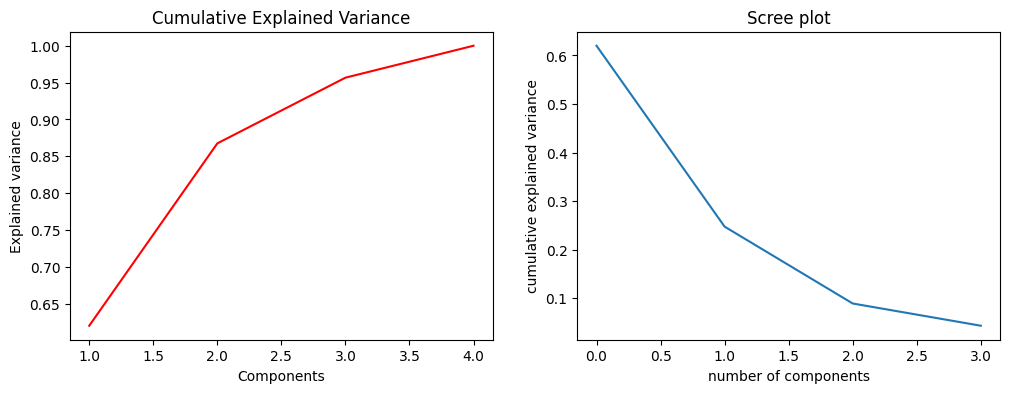

In [15]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

# Cumulative variance plot
ax[0].set_ylabel('Explained variance')
ax[0].set_xlabel('Components')
ax[0].plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
ax[0].set_title("Cumulative Explained Variance")

# Scree plot
ax[1].plot(std_pca.explained_variance_ratio_)
ax[1].set_xlabel('number of components')
ax[1].set_ylabel('cumulative explained variance')
ax[1].set_title("Scree plot")
plt.show()

In this case we only have 4 variables, so it won't be too difficult to make a decision because all are contributing to variance.
From the two plots above we can probably say that the first 3 PCs are the ones to take for cluster analysis, as these explain 95% of total variance.

In [16]:
# Selecting the first 3 PCs
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = arrests_df['City'])
pca_df.head()

,0,1,2
City,,,
Alabama,0.99,1.13,-0.44
Alaska,1.95,1.07,2.04
Arizona,1.76,-0.75,0.05
Arkansas,-0.14,1.12,0.11
California,2.52,-1.54,0.60


## Hierarchical clustering
First, we will use hierarchical clustering on the PCA prepared above.

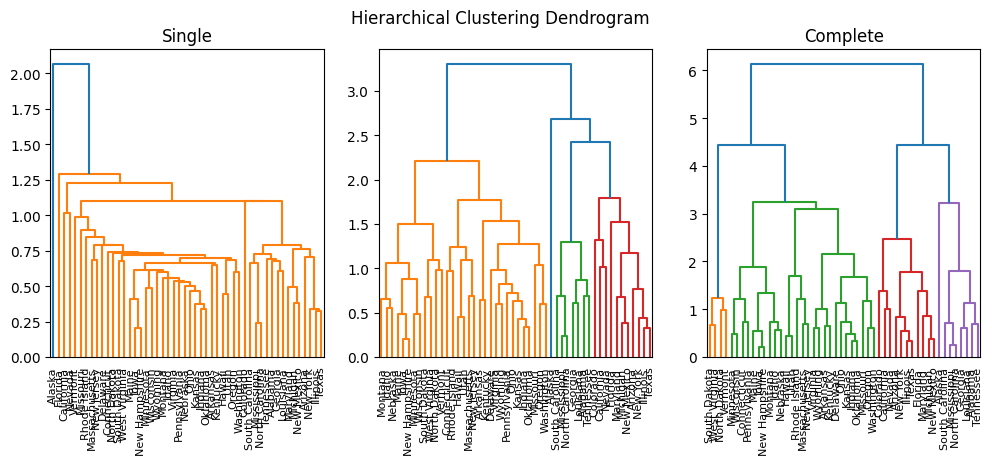

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1)

dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

Going for the complete linkage

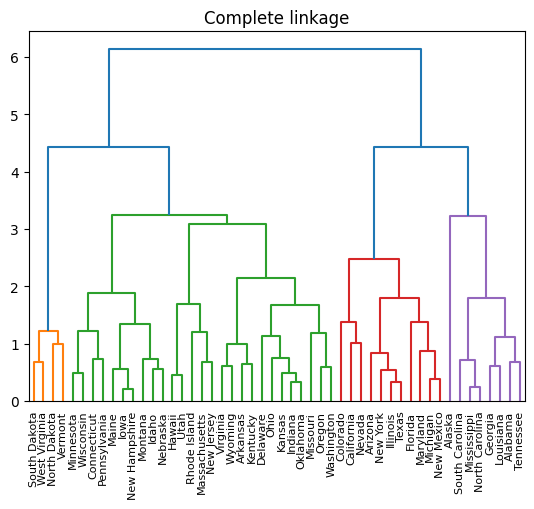

In [25]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

## K-mean clustering
Using K = 3 as decided from previous analysis, we will run the K-means clustering

No handles with labels found to put in legend.


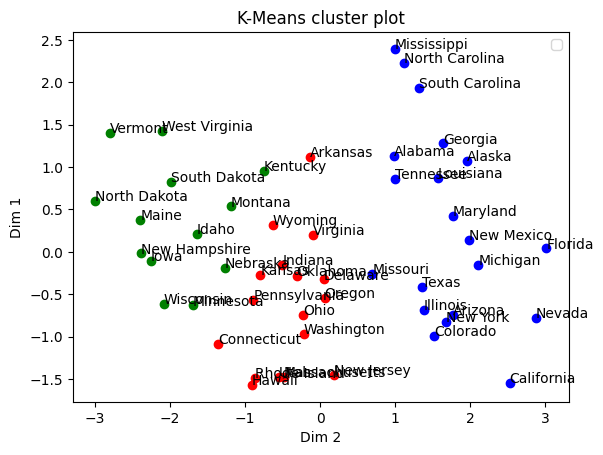

In [26]:
from sklearn.cluster import KMeans

# Extracting PC1 and PC2
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = arrests_df['City'][i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()